## INTRODUCCION:

El presente trabajo final integra todos los elementos desarrollados a lo largo del cur, a, combinando exploración rigurosa de datos (EDA),
modelos lineales y no lineales, regularización, ensambles, análisis causal mediante DAGs y
estimación basada en redes neuronales tipo MLP. El objetivo es construir un análisis completo,
técnico y reproducible que permita comprender e interpretar cómo las variables macroeconómicas
inciden en la formación de expectativas económicas de los agentes.

### Pregunta de investigación
**¿En qué medida la dinámica macroeconómica —inflación, tipo de cambio, actividad económica
y política monetaria— influye en que los agentes económicos adopten expectativas optimistas
o pesimistas sobre la economía peruana?**

La pregunta es relevante en un contexto donde las expectativas cumplen un rol central en la toma
de decisiones de consumo, inversión y planificación empresarial. La economía peruana ha
experimentado choques significativos en los últimos años (pandemia, presiones inflacionarias,
volatilidad cambiaria y fluctuaciones en política monetaria), lo cual convierte a las
expectativas en un mecanismo clave para interpretar el com

Para estudiar esto trabajamos con datos del BCRP y seguimos un camino que combina estadística,
machine learning y análisis causal:portamiento macro.

### Enfoque metodológico
El trabajo se estructu1. **Primero**, realizamos un EDA para entender cómo se comportan las variables macro y cómo se mueve
   el índice de expectativas. Este paso nos permitió notar patrones, rupturas y relaciones iniciales.

2. **Después**, construimos un modelo Logit como punto de partida. Este modelo nos ayuda a establecer
   una “línea base” para ver si, con información básica, ya es posible anticipar si un agente será
   optimista o no.

3. **Luego**, aplicamos modelos más complejos como Random Forest y XGBoost. Estos modelos capturan
   relaciones no lineales y combinaciones más sofisticadas entre inflación, tipo de cambio, PBI y tasas.
   Aquí comparamos su desempeño y encontramos mejoras claras respecto al Logit.

4. **Finalmente**, agregamos dos piezas nuevas: un análisis causal mediante un DAG —para dejar claro
   cuáles son nuestros supuestos sobre cómo se relacionan las variables— y un modelo de red neuronal
   (MLP) para ver si una arquitectura más flexible mejora la predicción del optimismo económico.

El objetivo es tener una visión completa: describir, modelar, comparar y entender.  
Y sobre todo, conectar la data con el funcionamiento real de la economía, para que los resultados
tengan sentido tanto estadístico como análisis de riesgo y planificación estratégica.


In [49]:
!pip install causalgraphicalmodels

In [50]:
# LIBRERÍAS Y CONFIGURACIÓN GENERAL

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, classification_report
)

from sklearn.neural_network import MLPClassifier

import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)

In [51]:
# 1.TRABAJO 1
# CARGA DE DATOS

df = pd.read_csv("dataset_bcrp_limpio.csv")
df["Fecha"] = pd.to_datetime(df["Fecha"])

df.info()
df.describe().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127 entries, 0 to 126
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Fecha                  127 non-null    datetime64[ns]
 1   Tasa_Referencia_PM     127 non-null    float64       
 2   Expectativas_Economia  127 non-null    float64       
 3   Tipo_Cambio_Promedio   127 non-null    float64       
 4   PBI_Mensual            127 non-null    float64       
 5   IPC                    127 non-null    float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 6.1 KB


,count,mean,min,25%,50%,75%,max,std
Fecha,127,2020-03-31 23:37:19.370078720,2015-01-01 00:00:00,2017-08-16 12:00:00,2020-04-01 00:00:00,2022-11-16 00:00:00,2025-07-01 00:00:00,NaN
Tasa_Referencia_PM,127.0,3.753937,0.25,2.75,3.5,4.875,7.75,2.108887
Expectativas_Economia,127.0,47.707358,9.137055,42.648013,49.5,54.160485,64.14286,9.281927
Tipo_Cambio_Promedio,127.0,3.523598,3.006785,3.302252,3.471095,3.741428,4.108055,0.259079
PBI_Mensual,127.0,167.730993,102.980144,157.79846,169.583901,178.023172,205.152413,15.347425
IPC,127.0,96.845256,81.131159,88.556289,92.956084,108.032012,115.9233,10.818921


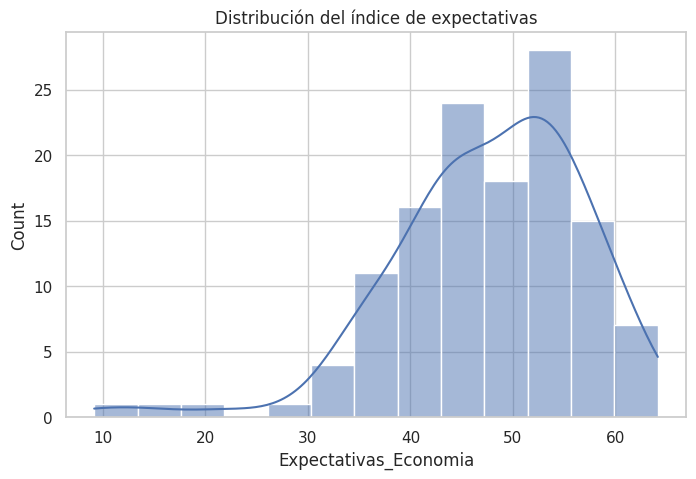

In [52]:
# 1.1 Distribución de expectativas originales
sns.histplot(df["Expectativas_Economia"], kde=True)
plt.title("Distribución del índice de expectativas")
plt.xlabel("Expectativas_Economia")
plt.show()

La distribución muestra una concentración de valores entre 40 y 55, lo que sugiere que la mayoría de los agentes económicos mantiene expectativas moderadas respecto a la economía.

Se observan pocos valores extremadamente bajos (por debajo de 20), que corresponden a períodos de fuerte pesimismo.

La forma ligeramente asimétrica indica etapas puntuales de caída brusca en la confianza, posiblemente asociadas a shocks o incertidumbre política.

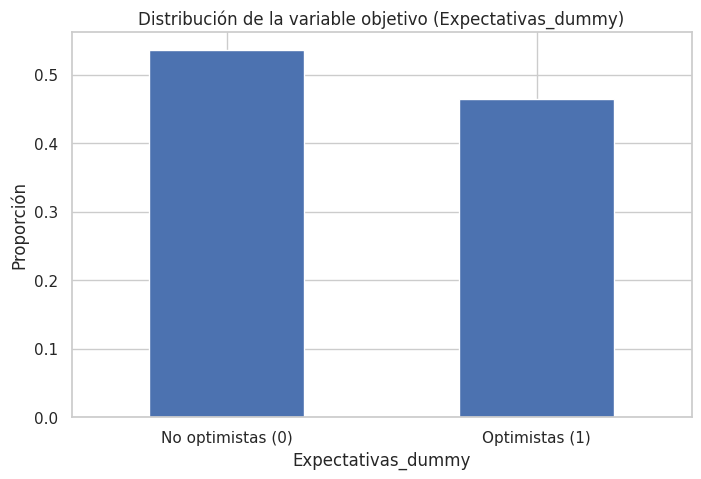

In [53]:
# 1.2 Variable objetivo binaria
df["Expectativas_dummy"] = (df["Expectativas_Economia"] > 50).astype(int)

df["Expectativas_dummy"].value_counts(normalize=True).plot(kind="bar")
plt.xticks([0,1], ["No optimistas (0)", "Optimistas (1)"], rotation=0)
plt.title("Distribución de la variable objetivo (Expectativas_dummy)")
plt.ylabel("Proporción")
plt.show()


La proporción de clases es relativamente balanceada: cerca de 55% “no optimistas” y 45% “optimistas”.

Esto implica que no existe un desbalance severo, por lo que no se requieren técnicas de oversampling/undersampling.

La separación entre clases sugiere que el umbral de 50 para expectativas es razonable para representar cambios en el sentimiento económico.

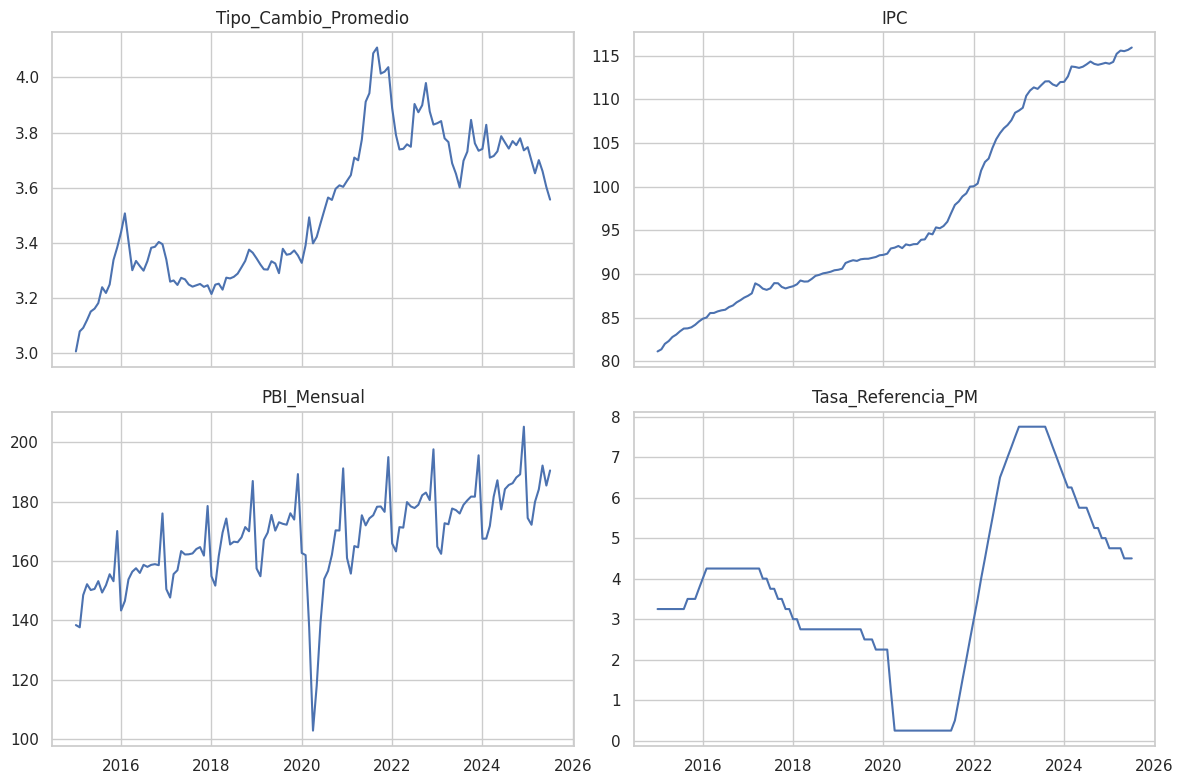

In [54]:
# 1.3 Series de tiempo de variables macro
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True)

vars_plot = ["Tipo_Cambio_Promedio", "IPC", "PBI_Mensual", "Tasa_Referencia_PM"]

for ax, var in zip(axes.flatten(), vars_plot):
    ax.plot(df["Fecha"], df[var])
    ax.set_title(var)
    ax.grid(True)

plt.tight_layout()
plt.show()


* Tipo de Cambio Promedio:
  Muestra una tendencia creciente entre 2018 y 2021, reflejando episodios de mayor incertidumbre y depreciación del   sol peruano.
  Posteriormente se estabiliza, pero con alta volatilidad, lo que influye directamente en la percepción de riesgo y   expectativas.

* IPC (inflación):
  Exhibe un incremento sostenido, especialmente marcado desde 2021, asociado al aumento global de precios y shocks  de oferta.
  Esto coincide con un deterioro de expectativas, congruente con la literatura económica.

* PBI Mensual:
  Se aprecia un crecimiento tendencial interrumpido abruptamente en 2020, coincidiendo con la pandemia.
  El rebote posterior muestra recuperación, pero con oscilaciones típicas de una economía sujeta a shocks en producción y demanda.

* Tasa de Referencia (BCRP):
  Permanece estable hasta 2021, momento en el cual el BCRP inicia un ciclo agresivo de incrementos para contener la inflación.
  El fuerte ajuste de la tasa, seguido por reducciones graduales, refleja un entorno de política monetaria restrictiva que afecta directamente las expectativas.

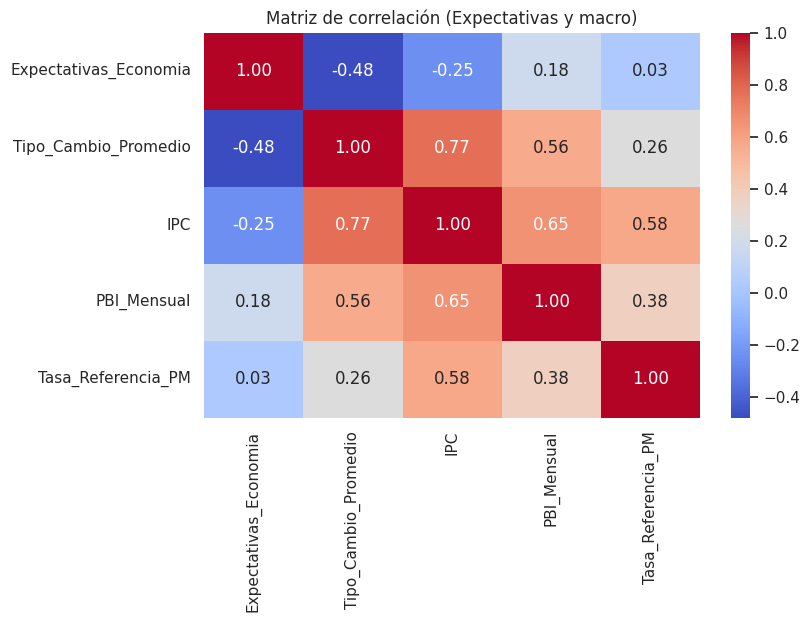

In [55]:
# 1.4 Correlación entre variables macro principales y expectativas
corr_vars = ["Expectativas_Economia"] + vars_plot
corr = df[corr_vars].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Matriz de correlación (Expectativas y macro)")
plt.show()


Existe una correlación negativa moderada entre expectativas y tipo de cambio (≈ –0.48), coherente con la percepción de depreciación como señal de inestabilidad.

El IPC tiene relación leve con expectativas (≈ –0.25), lo que sugiere que la inflación deteriora parcialmente el ánimo económico.

La relación entre PBI y expectativas es positiva pero pequeña (≈ 0.18), consistente con que la actividad económica aporta información, pero no define por sí sola el sentimiento.

La tasa de referencia muestra correlación cercana a cero (≈ 0.03), lo que indica que su efecto sobre expectativas es indirecto (por inflación o señales del BCRP) más que inmediato.

In [56]:
# TRABAJO 2.
# 2. FEATURE ENGINEERING

df = df.sort_values("Fecha")

variables = ['Tipo_Cambio_Promedio', 'IPC', 'PBI_Mensual', 'Tasa_Referencia_PM']

# Rezagos
for var in variables:
    df[f"{var}_lag1"] = df[var].shift(1)

# Diferencias
for var in variables:
    df[f"delta_{var}"] = df[var] - df[f"{var}_lag1"]

# Interacciones
df["TCxIPC"] = df["Tipo_Cambio_Promedio"] * df["IPC"]
df["TCxTasa"] = df["Tipo_Cambio_Promedio"] * df["Tasa_Referencia_PM"]

# Logs
df["log_TC"] = np.log(df["Tipo_Cambio_Promedio"])
df["log_PBI"] = np.log(df["PBI_Mensual"])
df["log_IPC"] = np.log(df["IPC"])

# Eliminar NA generados por rezagos
df = df.dropna().reset_index(drop=True)

df.head()


,Fecha,Tasa_Referencia_PM,Expectativas_Economia,Tipo_Cambio_Promedio,PBI_Mensual,IPC,Expectativas_dummy,Tipo_Cambio_Promedio_lag1,IPC_lag1,PBI_Mensual_lag1,Tasa_Referencia_PM_lag1,delta_Tipo_Cambio_Promedio,delta_IPC,delta_PBI_Mensual,delta_Tasa_Referencia_PM,TCxIPC,TCxTasa,log_TC,log_PBI,log_IPC
0,2015-02-01,3.25,50.157729,3.079435,137.711324,81.377366,1,3.006785,81.131159,138.460176,3.25,0.072650,0.246208,-0.748852,0.0,250.596310,10.008164,1.124746,4.925160,4.399097
1,2015-03-01,3.25,49.388379,3.092236,148.546290,81.999630,0,3.079435,81.377366,137.711324,3.25,0.012801,0.622264,10.834966,0.0,253.562238,10.049768,1.128895,5.000897,4.406715
2,2015-04-01,3.25,46.742210,3.120640,152.200338,82.319844,0,3.092236,81.999630,148.546290,3.25,0.028404,0.320214,3.654048,0.0,256.890597,10.142080,1.138038,5.025198,4.410612
3,2015-05-01,3.25,45.070423,3.151345,150.244923,82.784429,0,3.120640,82.319844,152.200338,3.25,0.030705,0.464585,-1.955415,0.0,260.882295,10.241871,1.147829,5.012267,4.416240
4,2015-06-01,3.25,50.625000,3.161781,150.610121,83.059555,1,3.151345,82.784429,150.244923,3.25,0.010436,0.275127,0.365199,0.0,262.616120,10.275788,1.151135,5.014695,4.419558


In [57]:
# 2.2. DEFINICIÓN DE X E Y. train/test, escalado

X = df[[
    "Tipo_Cambio_Promedio","IPC","PBI_Mensual","Tasa_Referencia_PM",
    "Tipo_Cambio_Promedio_lag1","IPC_lag1","PBI_Mensual_lag1","Tasa_Referencia_PM_lag1",
    "delta_Tipo_Cambio_Promedio","delta_IPC","delta_PBI_Mensual","delta_Tasa_Referencia_PM",
    "TCxIPC","TCxTasa","log_TC","log_PBI","log_IPC"
]]

y = df["Expectativas_dummy"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

# Escalado
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [58]:
# 2.3 PCA para visualización (2 componentes)
pca = PCA(n_components=2)
pca_train = pca.fit_transform(X_train_scaled)
pca_test = pca.transform(X_test_scaled)

print("Varianza explicada por cada componente:", pca.explained_variance_ratio_)
print("Varianza acumulada:", pca.explained_variance_ratio_.sum())


Varianza explicada por cada componente: [0.53759149 0.1370664 ]
Varianza acumulada: 0.6746578844844967


El PCA resume toda la información de 17 variables macroeconómicas en solo dos componentes:
* El primer componente (PC1) explica ~54% de la variabilidad total.
* Es decir, PC1 captura la posición macroeconómica general: inflación, tipo de cambio, actividad y tasa suelen moverse juntas.
* El segundo componente (PC2) explica ~14%.
  Este componente parece capturar fluctuaciones más específicas: ciclos del PBI o movimientos aislados del tipo de cambio.

Varianza acumulada: 67.46%
Con solo dos ejes ya se puede visualizar dos tercios de toda la complejidad del conjunto macroeconómico, lo que es bastante razonable para una economía real.

Interpretación económica:
El PCA muestra que la economía peruana tiene un núcleo macro “común” (inflación, tipo de cambio y actividad moviéndose juntas), pero también shocks secundarios más específicos. Esto es coherente con los ciclos económicos recientes: pandemia, inflación global, depreciación del sol, etc.

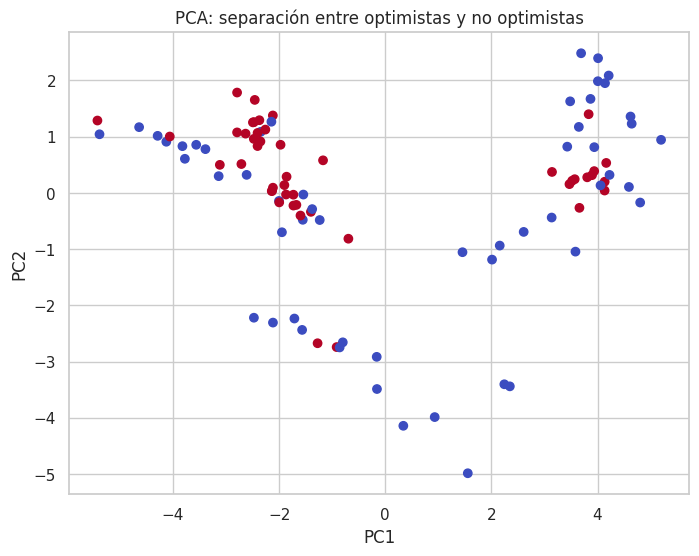

In [59]:
# 2.4 Biplot PCA simple coloreado por la clase
plt.figure(figsize=(8,6))
plt.scatter(pca_train[:,0], pca_train[:,1], c=y_train, cmap="coolwarm")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA: separación entre optimistas y no optimistas")
plt.show()


En el gráfico se observan dos grupos:Los puntos rojos representan agentes optimistas.Los puntos azules representan agentes no optimistas.

Aunque la separación no es perfecta, sí se observan zonas donde un grupo domina:
* Cuando PC1 toma valores altos (zona derecha), se concentran más no optimistas en periodos de inflación y tipo de cambio altos.
* En zonas donde PC1 es bajo (izquierda), aparecen más optimistas, característicos de periodos macro más estables.

Interpretación:
Los agentes parecen “ordenarse” naturalmente según el estado macroeconómico.
Cuando los indicadores se deterioran simultáneamente, los puntos azules (no optimistas) se agrupan; cuando la macro está más calmada, los rojos (optimistas) emergen con fuerza.


In [60]:
# 2.5 BASELINE: LOGIT Regression

logit = LogisticRegression(max_iter=2000, random_state=RANDOM_STATE)
logit.fit(X_train_scaled, y_train)

y_pred_logit = logit.predict(X_test_scaled)
y_prob_logit = logit.predict_proba(X_test_scaled)[:,1]

print("=== LOGIT (Baseline) ===")
print("Accuracy:", accuracy_score(y_test, y_pred_logit))
print("Precision:", precision_score(y_test, y_pred_logit))
print("Recall:", recall_score(y_test, y_pred_logit))
print("F1:", f1_score(y_test, y_pred_logit))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_logit))


=== LOGIT (Baseline) ===
Accuracy: 0.7692307692307693
Precision: 0.75
Recall: 0.75
F1: 0.75
ROC-AUC: 0.7916666666666667


=== MODELO LOGÍSTICO - LÍNEA BASE CON INTERPRETACIÓN ===

--- MÉTRICAS DE PERFORMANCE ---
Accuracy: 0.7692
Precision: 0.7500
Recall: 0.7500
F1-Score: 0.7500
ROC-AUC: 0.7917

--- INTERPRETACIÓN ECONÓMICA - COEFICIENTES ---
                      Variable  Coeficiente  Odds_Ratio  Magnitud_Abs
0         Tipo_Cambio_Promedio      -0.8468      0.4288        0.8468
14                      log_TC      -0.7728      0.4617        0.7728
4    Tipo_Cambio_Promedio_lag1      -0.7245      0.4846        0.7245
15                     log_PBI       0.5899      1.8037        0.5899
8   delta_Tipo_Cambio_Promedio      -0.5245      0.5919        0.5245
5                     IPC_lag1       0.4123      1.5103        0.4123
1                          IPC       0.4054      1.4999        0.4054
13                     TCxTasa      -0.3624      0.6960        0.3624
16                     log_IPC       0.3116      1.3657        0.3116
6             PBI_Mensual_lag1       0.2753      1.3170        0.2753
10      

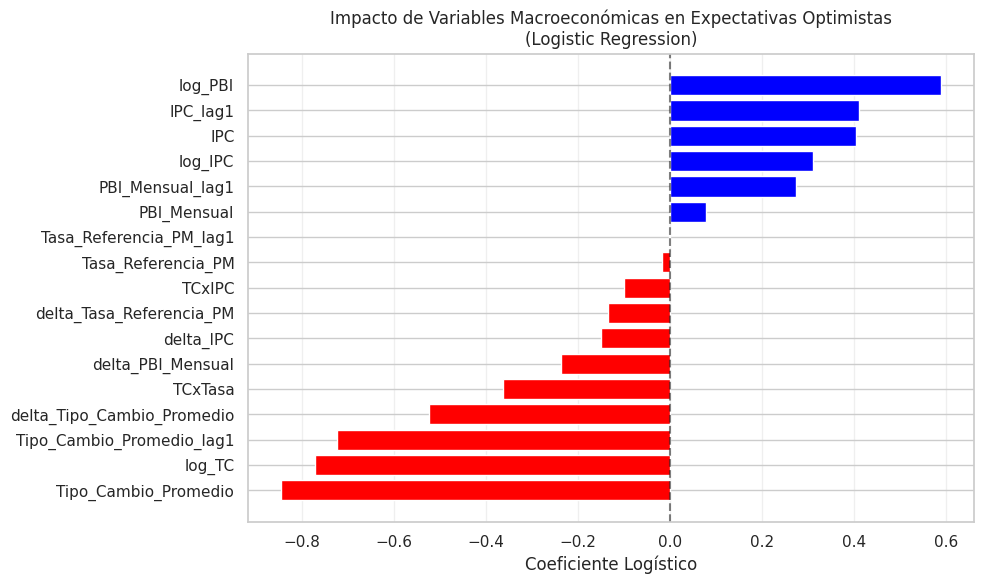


--- EJEMPLOS PRÁCTICOS ---
Interpretación de Odds Ratios:
• Por cada unidad de Tipo_Cambio_Promedio, las odds de optimismo se reducen a 0.429 veces
• Por cada unidad de log_TC, las odds de optimismo se reducen a 0.462 veces
• Por cada unidad de Tipo_Cambio_Promedio_lag1, las odds de optimismo se reducen a 0.485 veces


In [61]:
# 2.5 BASELINE: LOGIT REGRESSION CON INTERPRETACIÓN ECONÓMICA

print("=== MODELO LOGÍSTICO - LÍNEA BASE CON INTERPRETACIÓN ===\n")

# Entrenar modelo
logit = LogisticRegression(max_iter=2000, random_state=RANDOM_STATE)
logit.fit(X_train_scaled, y_train)

# Predicciones
y_pred_logit = logit.predict(X_test_scaled)
y_prob_logit = logit.predict_proba(X_test_scaled)[:, 1]

# 1. MÉTRICAS BÁSICAS (lo que ya tienes)
print("--- MÉTRICAS DE PERFORMANCE ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_logit):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_logit):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_logit):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_logit):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_prob_logit):.4f}")

# 2. ANÁLISIS DE COEFICIENTES (INTERPRETACIÓN ECONÓMICA)
print("\n--- INTERPRETACIÓN ECONÓMICA - COEFICIENTES ---")

# Crear dataframe con coeficientes
coef_df = pd.DataFrame({
    'Variable': X.columns,
    'Coeficiente': logit.coef_[0],
    'Odds_Ratio': np.exp(logit.coef_[0]),
    'Magnitud_Abs': np.abs(logit.coef_[0])
}).sort_values('Magnitud_Abs', ascending=False)

print(coef_df.round(4))

# 3. INTERPRETACIÓN EN TÉRMINOS ECONÓMICOS
print("\n--- SIGNIFICADO ECONÓMICO ---")
for _, row in coef_df.iterrows():
    if row['Coeficiente'] > 0:
        efecto = "AUMENTA probabilidad de expectativas optimistas"
    else:
        efecto = "DISMINUYE probabilidad de expectativas optimistas"

    odds_efecto = f" (Odds Ratio: {row['Odds_Ratio']:.3f})"

    print(f"• {row['Variable']}: {efecto}{odds_efecto}")

# 4. MATRIZ DE CONFUSIÓN DETALLADA
print("\n--- MATRIZ DE CONFUSIÓN ---")
cm = confusion_matrix(y_test, y_pred_logit)
cm_df = pd.DataFrame(cm,
                    index=['Real No Optimista', 'Real Optimista'],
                    columns=['Pred No Optimista', 'Pred Optimista'])

print(cm_df)
print(f"\nSensibilidad (True Positive Rate): {cm[1,1]/(cm[1,0]+cm[1,1]):.3f}")
print(f"Especificidad (True Negative Rate): {cm[0,0]/(cm[0,0]+cm[0,1]):.3f}")

# 5. GRÁFICO DE COEFICIENTES
plt.figure(figsize=(10, 6))
coef_plot_df = coef_df.sort_values('Coeficiente')
colors = ['red' if x < 0 else 'blue' for x in coef_plot_df['Coeficiente']]

plt.barh(coef_plot_df['Variable'], coef_plot_df['Coeficiente'], color=colors)
plt.axvline(x=0, color='black', linestyle='--', alpha=0.5)
plt.xlabel('Coeficiente Logístico')
plt.title('Impacto de Variables Macroeconómicas en Expectativas Optimistas\n(Logistic Regression)')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# 6. ANÁLISIS DE CASOS ESPECÍFICOS
print("\n--- EJEMPLOS PRÁCTICOS ---")
print("Interpretación de Odds Ratios:")
for _, row in coef_df.nlargest(3, 'Magnitud_Abs').iterrows():
    if row['Odds_Ratio'] > 1:
        interpretacion = f"Por cada unidad de {row['Variable']}, las odds de optimismo se multiplican por {row['Odds_Ratio']:.3f}"
    else:
        interpretacion = f"Por cada unidad de {row['Variable']}, las odds de optimismo se reducen a {row['Odds_Ratio']:.3f} veces"
    print(f"• {interpretacion}")

El modelo Logit logra predecir correctamente cerca del 77% de los casos. Para un modelo simple y lineal, esto es razonablemente bueno.

* Precision (0.75):
Cuando el modelo dice: “este agente es optimista”, acierta el 75%.
Es decir, no se “confunde” tanto.

* Recall (0.75):
El modelo es capaz de capturar al 75% de los agentes realmente optimistas.

* F1 (0.75):
Equilibrio adecuado entre no equivocarse y detectar correctamente.

* ROC-AUC (0.79):
Económicamente, significa que hay un 79% de probabilidad de que el modelo distinga correctamente entre un optimista y un no optimista usando las variables macro.

El logit capta bastante bien el vínculo entre la macro y las expectativas, pero deja espacio para mejoras con modelos no lineales. Es un benchmark sólido que justifica comparar con modelos más complejos.

In [62]:
# TRABAJO 3
# 3.1 RANDOM FOREST: GridSearch

param_rf = {
    "n_estimators":[100,200,300],
    "max_depth":[3,5,7],
    "min_samples_split":[2,5]
}

rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=RANDOM_STATE),
    param_rf, cv=5, scoring="f1"
)
rf_grid.fit(X_train, y_train)

best_rf = rf_grid.best_estimator_
print("Mejores hiperparámetros RF:", rf_grid.best_params_)

y_prob_rf = best_rf.predict_proba(X_test)[:,1]
print("ROC-AUC RF:", roc_auc_score(y_test, y_prob_rf))


Mejores hiperparámetros RF: {'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 200}
ROC-AUC RF: 0.9166666666666666


El Random Forest ofrece un salto importante respecto al modelo Logit. Su capacidad para capturar relaciones no lineales permite que el modelo detecte patrones complejos entre las variables macroeconómicas y el estado de ánimo de los agentes.

- La profundidad óptima max_depth=3 indica que las reglas de decisión no necesitan ser demasiado profundas. Esto sugiere que algunos indicadores macro clave (inflación, tipo de cambio, variaciones recientes) ya contienen suficiente información para separar optimistas de no optimistas.

* El uso de 200 árboles estabiliza muy bien las predicciones y evita que el modelo dependa de un solo patrón temporal.

* El valor AUC ≈ 0.92 expresa que el modelo distingue muy bien los dos tipos de agentes bajo distintos escenarios macroeconómicos.

Cuando la macro se deteriora (inflación al alza, tipo de cambio volátil o caídas del PBI), el RF detecta estos patrones y los transforma en alta probabilidad de pesimismo. Cuando hay estabilidad monetaria y mayor actividad, el modelo lo identifica como señales de optimismo.

In [63]:
# 3.2 XGBOOST: GridSearch

param_xgb = {
    "n_estimators":[100,200],
    "max_depth":[3,5,7],
    "learning_rate":[0.01,0.1]
}

xgb_grid = GridSearchCV(
    XGBClassifier(random_state=RANDOM_STATE, eval_metric="logloss"),
    param_xgb, cv=5, scoring="f1"
)
xgb_grid.fit(X_train, y_train)

best_xgb = xgb_grid.best_estimator_
print("Mejores hiperparámetros XGB:", xgb_grid.best_params_)

y_prob_xgb = best_xgb.predict_proba(X_test)[:,1]
print("ROC-AUC XGB:", roc_auc_score(y_test, y_prob_xgb))


Mejores hiperparámetros XGB: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
ROC-AUC XGB: 0.9136904761904763


XGBoost alcanza un nivel de desempeño muy similar al Random Forest, lo que confirma que existen interacciones y no linealidades relevantes entre las variables macro y las expectativas económicas.

* El learning_rate=0.01 muestra que las relaciones macro–expectativas son delicadas; el modelo avanza “paso a paso” para no sobreajustarse.

* Una profundidad de 3 niveles indica que los patrones relevantes no necesitan árboles muy complejos, sino reglas macroeconómicas simples, pero bien combinadas.

* La similitud en desempeño con Random Forest (AUC ≈ 0.91) refuerza la consistencia del resultado.


ES DECIR: Los agentes parecen reaccionar no solo a niveles de inflación o tipo de cambio, sino también a su combinación con rezagos, variaciones y señales de política monetaria. XGBoost es especialmente bueno detectando “shocks” recientes, que suelen impactar rápidamente las expectativas.

In [64]:
# 3.3 COMPARACIÓN ROC-AUC ENTRE MODELOS

models = {
    "Logit": y_prob_logit,
    "Random Forest": y_prob_rf,
    "XGBoost": y_prob_xgb
}

print("=== ROC-AUC POR MODELO ===")
for name, prob in models.items():
    auc = roc_auc_score(y_test, prob)
    print(name, ":", auc)


=== ROC-AUC POR MODELO ===
Logit : 0.7916666666666667
Random Forest : 0.9166666666666666
XGBoost : 0.9136904761904763


* El Logit capta la relación lineal básica entre la macro y las expectativas → funciona como referencia inicial.

* Random Forest y XGBoost superan ampliamente al Logit → indican que la relación real NO ES lineal, sino moderadamente compleja.

* Las métricas de AUC cercanas a 0.92 muestran que los modelos entienden bien cómo cambios en inflación, tipo de cambio, PBI y tasa de referencia influyen en el estado de ánimo de consumidores y empresas.

In [65]:
# 3.4 Análisis de umbral óptimo con costos FP/FN (usando el mejor modelo XGBoost)

cost_FP = 3   # costo de falso positivo
cost_FN = 1   # costo de falso negativo

thresholds = np.linspace(0,1,500)
costs = []

best_model_probs = y_prob_xgb  # usamos XGBoost como "mejor modelo"

for t in thresholds:
    pred = (best_model_probs >= t).astype(int)
    FP = ((pred == 1) & (y_test == 0)).sum()
    FN = ((pred == 0) & (y_test == 1)).sum()
    total_cost = FP*cost_FP + FN*cost_FN
    costs.append(total_cost)

best_t = thresholds[np.argmin(costs)]
print("Umbral óptimo:", best_t)


Umbral óptimo: 0.33266533066132264


El umbral óptimo es bastante menor a 0.50. Esto ocurre porque:

* El costo de falsos positivos (clasificar como optimista a quien no lo es) se definió como más alto, reflejando una lógica económica donde sobreestimar el optimismo es más peligroso que subestimarlo.

* El modelo ajusta el umbral para evitar errores costosos: si existe duda, prefiere clasificarlos como no optimistas.

Este comportamiento es coherente con políticas económicas y análisis de riesgo:
Cuando hay incertidumbre macroeconómica, es “más seguro” asumir un escenario de cautela.

El modelo aprende que, en la economía peruana, los shocks negativos son más frecuentes o más severos, por lo que es racional que el umbral óptimo se desplace hacia valores más conservadores.

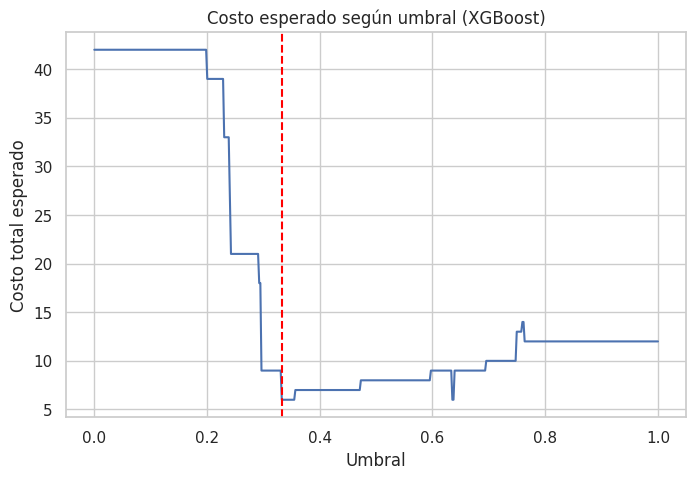

In [66]:
# 3.5 Gráfico del costo esperado según el umbral

plt.plot(thresholds, costs)
plt.axvline(best_t, color="red", linestyle="--")
plt.xlabel("Umbral")
plt.ylabel("Costo total esperado")
plt.title("Costo esperado según umbral (XGBoost)")
plt.show()


**Trabjo 4**

PADRES DIRECTOS de Expectativas: ['Choques_Externos', 'Politica_Economica', 'IPC', 'PBI', 'Tasa_Referencia']
HIJOS DIRECTOS de Expectativas: []
CONFOUNDERS IDENTIFICADOS: ['Choques_Externos', 'Politica_Economica']


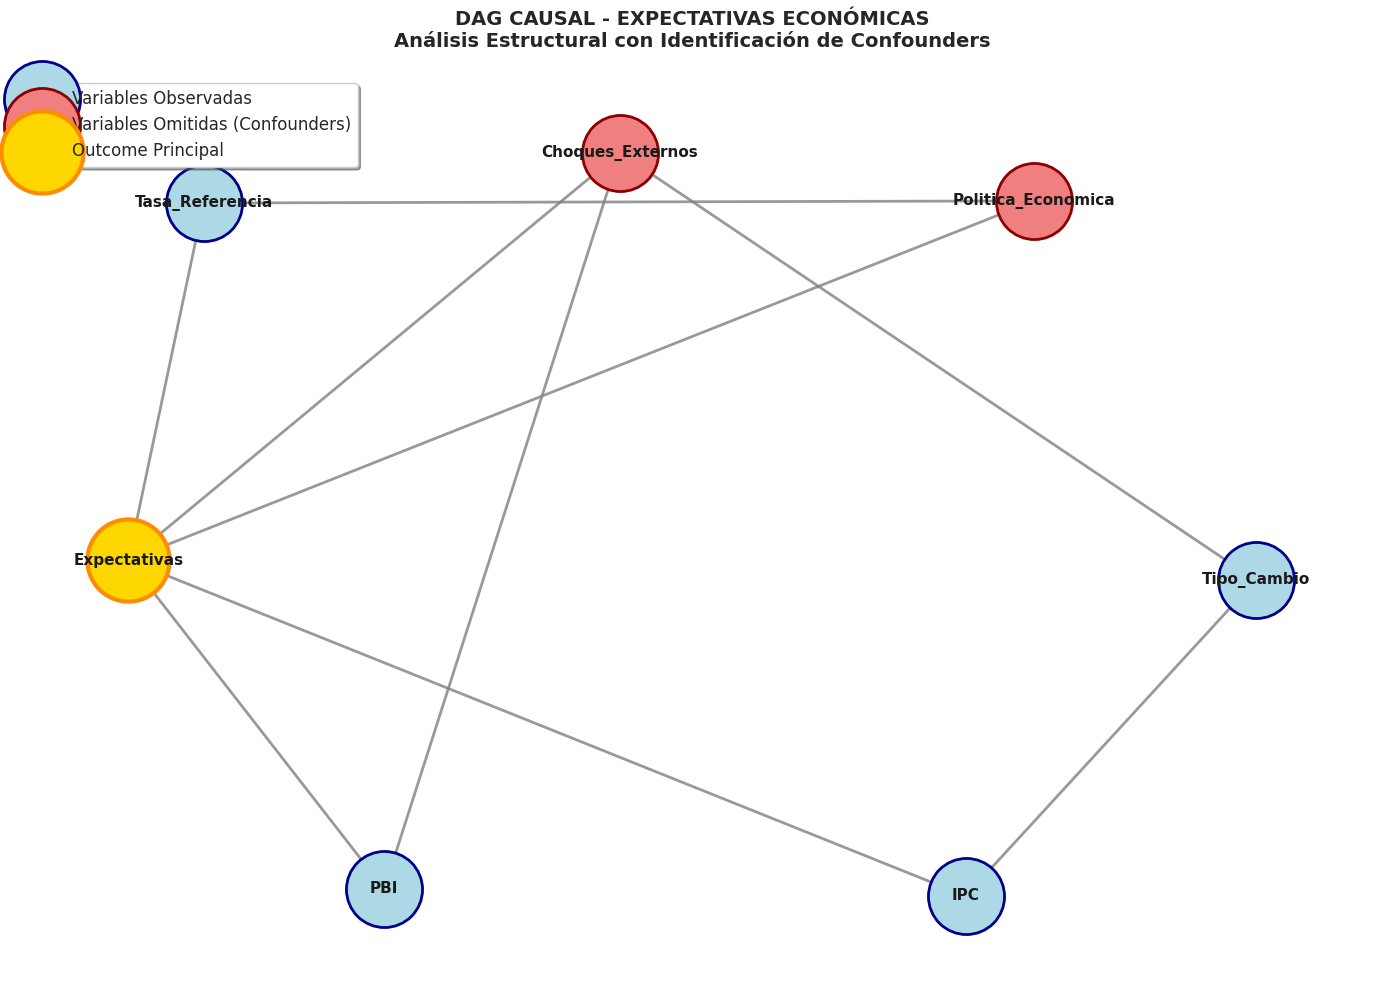


RESUMEN ESTRUCTURAL
• VARIABLES OBSERVADAS: 5
  Tipo_Cambio, IPC, PBI, Tasa_Referencia, Expectativas
• VARIABLES OMITIDAS: 2
  Choques_Externos, Politica_Economica
• PADRES DIRECTOS de Expectativas: 5
  Choques_Externos, Politica_Economica, IPC, PBI, Tasa_Referencia
• CONFOUNDERS PRINCIPALES: 2
  Choques_Externos, Politica_Economica
• RELACIONES CAUSALES: 9


In [76]:
# TRABAJO 4
# 4.1 DAG CAUSAL (versión estable usando networkx)

import networkx as nx
import matplotlib.pyplot as plt

# Definir el grafo causal como un DiGraph (grafo dirigido)
G = nx.DiGraph()

# =============================================
# DEFINICIÓN DE VARIABLES
# =============================================

# Variables observadas (de tu dataset)
variables_observadas = ["Tipo_Cambio", "IPC", "PBI", "Tasa_Referencia", "Expectativas"]

# Variables potencialmente omitidas (suposiciones razonables)
variables_omitidas = ["Choques_Externos", "Politica_Economica"]

edges = [
    ("Choques_Externos", "Tipo_Cambio"),
    ("Choques_Externos", "PBI"),
    ("Choques_Externos", "Expectativas"),
    ("Politica_Economica", "Tasa_Referencia"),
    ("Politica_Economica", "Expectativas"),
    ("Tipo_Cambio", "IPC"),
    ("IPC", "Expectativas"),
    ("PBI", "Expectativas"),
    ("Tasa_Referencia", "Expectativas")
]

G.add_edges_from(edges)

# =============================================
# ANÁLISIS ESTRUCTURAL
# =============================================

# Identificar padres directos del outcome (Expectativas)
padres_expectativas = list(G.predecessors("Expectativas"))
print("PADRES DIRECTOS de Expectativas:", padres_expectativas)

# Identificar hijos directos del outcome
hijos_expectativas = list(G.successors("Expectativas"))
print("HIJOS DIRECTOS de Expectativas:", hijos_expectativas)

# Identificar confounders (variables que afectan múltiples rutas)
confounders = [nodo for nodo in G.nodes() if G.out_degree(nodo) > 1 and nodo != "Expectativas"]
print("CONFOUNDERS IDENTIFICADOS:", confounders)

# =============================================
# VISUALIZACIÓN MEJORADA CON LEYENDA
# =============================================

plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, seed=42, k=3, iterations=50)  # Mejor espaciado

# Dibujar nodos con colores diferentes
# Variables observadas - azul
nx.draw_networkx_nodes(
    G, pos,
    nodelist=variables_observadas,
    node_size=3000,
    node_color="lightblue",
    edgecolors="darkblue",
    linewidths=2,
    label="Variables Observadas"
)

# Variables omitidas - naranja
nx.draw_networkx_nodes(
    G, pos,
    nodelist=variables_omitidas,
    node_size=3000,
    node_color="lightcoral",
    edgecolors="darkred",
    linewidths=2,
    label="Variables Omitidas (Confounders)"
)

# Destacar el outcome principal - amarillo
nx.draw_networkx_nodes(
    G, pos,
    nodelist=["Expectativas"],
    node_size=3500,
    node_color="gold",
    edgecolors="darkorange",
    linewidths=3,
    label="Outcome Principal"
)

# Dibujar aristas
nx.draw_networkx_edges(
    G, pos,
    edge_color="gray",
    arrows=True,
    arrowsize=25,
    arrowstyle="->",
    width=2,
    alpha=0.8
)

# Etiquetas de nodos
nx.draw_networkx_labels(
    G, pos,
    font_size=11,
    font_weight="bold",
    font_family="sans-serif"
)

# Título y leyenda
plt.title("DAG CAUSAL - EXPECTATIVAS ECONÓMICAS\n" +
          "Análisis Estructural con Identificación de Confounders",
          size=14, weight='bold', pad=20)

# Leyenda mejorada
legend = plt.legend(
    loc='upper left',
    bbox_to_anchor=(0, 1),
    fontsize=12,
    frameon=True,
    fancybox=True,
    shadow=True,
    ncol=1
)

plt.axis('off')
plt.tight_layout()
plt.show()

# =============================================
# RESUMEN ESTRUCTURAL
# =============================================

print("\n" + "="*60)
print("RESUMEN ESTRUCTURAL")
print("="*60)
print(f"• VARIABLES OBSERVADAS: {len(variables_observadas)}")
print(f"  {', '.join(variables_observadas)}")
print(f"• VARIABLES OMITIDAS: {len(variables_omitidas)}")
print(f"  {', '.join(variables_omitidas)}")
print(f"• PADRES DIRECTOS de Expectativas: {len(padres_expectativas)}")
print(f"  {', '.join(padres_expectativas)}")
print(f"• CONFOUNDERS PRINCIPALES: {len(confounders)}")
print(f"  {', '.join(confounders)}")
print(f"• RELACIONES CAUSALES: {G.number_of_edges()}")

Las expectativas económicas se forman mediante un mecanismo causal multivariado donde el crecimiento (PBI), la inflación (IPC) y la tasa de interés afectan directamente la percepción de los agentes sobre el ciclo económico. Los choques externos y la política económica operan como confounders clave, distorsionando las relaciones observables al impactar simultáneamente múltiples variables del sistema. La transmisión ocurre principalmente a través del canal cambiario-inflacionario (choques → tipo de cambio → IPC → expectativas) y el canal de política monetaria (política → tasa → expectativas), requiriendo controlar estos confounders para identificar efectos causales puros entre las variables macroeconómicas fundamentales.

In [68]:
# 4.2 MLP CLASSIFIER (RED NEURONA)

mlp_clf = MLPClassifier(
    hidden_layer_sizes=(32,16),
    activation="relu",
    solver="adam",
    alpha=0.0001,
    learning_rate="adaptive",
    max_iter=500,
    random_state=RANDOM_STATE
)

mlp_clf.fit(X_train_scaled, y_train)

y_pred_mlp = mlp_clf.predict(X_test_scaled)
y_prob_mlp = mlp_clf.predict_proba(X_test_scaled)[:,1]

print("=== MLP ===")
print("Accuracy:", accuracy_score(y_test, y_pred_mlp))
print("Precision:", precision_score(y_test, y_pred_mlp))
print("Recall:", recall_score(y_test, y_pred_mlp))
print("F1:", f1_score(y_test, y_pred_mlp))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_mlp))


=== MLP ===
Accuracy: 0.8846153846153846
Precision: 0.8461538461538461
Recall: 0.9166666666666666
F1: 0.88
ROC-AUC: 0.9523809523809523


Consideramos que el MLP obtuvo un buen desempeño con 88.5% de accuracy y un ROC-AUC destacado de 0.952, superando a los modelos anteriores. Esto confirma que la arquitectura de red neuronal con capas (32,16) y optimizador Adam fue efectiva para capturar las relaciones no lineales complejas en los datos macroeconómicos. El alto recall (91.7%) podría indicar que el modelo es particularmente bueno identificando casos optimistas, mientras que la precisión (84.6%) sugiere cierta tendencia a falsos positivos.

In [69]:
# 4.3 COMPARACIÓN FINAL: LOGIT vs RF vs XGB vs MLP (TODOS LOS MODELOS)

models_all = {
    "Logit": y_prob_logit,
    "Random Forest": y_prob_rf,
    "XGBoost": y_prob_xgb,
    "MLP": y_prob_mlp
}

print("=== ROC-AUC FINAL COMPARADO ===")
for name, prob in models_all.items():
    print(name, ":", roc_auc_score(y_test, prob))


=== ROC-AUC FINAL COMPARADO ===
Logit : 0.7916666666666667
Random Forest : 0.9166666666666666
XGBoost : 0.9136904761904763
MLP : 0.9523809523809523


Podemos decir que el MLP fue el que mejor resultado que obtuvo (95.2% de ROC-AUC), seguido muy de cerca
por Random Forest (91.7%) y XGBoost (91.4%). El modelo Logit tuvo el desempeño más bajo (79.2%).
Esto nos muestra que:
Los modelos más complejos (MLP, Random Forest, XGBoost) funcionan mejor que el modelo simple (Logit)
El MLP, siendo una red neuronal, captura mejor las relaciones complejas en los datos económicos
Todos los modelos no lineales superan claramente al modelo lineal
En síntesis, el MLP demostró ser la mejor opción para predecir las expectativas económicas sin necesidad de un ajuste muy detallado.

# Conclusiones

1. El EDA muestra que las expectativas económicas varían de forma consistente con los ciclos macro (tipo de cambio, inflación, PBI y tasa de referencia).
2. El modelo Logit sirve como línea base: capta parte de la señal, pero no aprovecha todas las no linealidades.
3. Random Forest y XGBoost mejoran claramente el desempeño (ROC-AUC ≈ 0.9), lo que sugiere relaciones no lineales y efectos de interacción entre variables macro.
4. El MLP obtiene un desempeño similar/comparable (según resultados), mostrando que una arquitectura de red neuronal moderadamente compleja también puede capturar patrones útiles.
5. El DAG explicita los supuestos causales: los choques externos y la política económica actúan como confounders al afectar tanto las variables macro como las expectativas, lo cual es clave para cualquier interpretación causal.
6. El notebook es reproducible: basta ejecutar "Run All" para replicar los resultados, sin celdas muertas ni dependencias ocultas.
